# Analyze with Integrated Gradients

In [1]:
import os
import torch
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
torch.cuda.device_count()

4

In [2]:
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM
import re
import random
import torch
from dataclasses import dataclass
from typing import Tuple, List, Dict, Any
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from captum.attr import LayerIntegratedGradients, IntegratedGradients

from metric_utils import em_for_interpretability

/home/hjh/.conda/envs/xai_final_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!which google-chrome

/usr/bin/google-chrome


## Load dataset & Model

In [4]:
# Load dataset
from datasets import load_from_disk

DATASET_PATH = "../../data/nq-swap-logit-lens-valid-samples"
dataset = load_from_disk(DATASET_PATH)
dataset

Dataset({
    features: ['question', 'org_context', 'org_answer', 'sub_context', 'sub_answer'],
    num_rows: 374
})

In [5]:
# Load model and tokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype="auto")

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


In [6]:
# print model structure
model.eval()
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [7]:
import re

# Preprocess input
def preprocess_function(examples):
    pattern = r"</?[a-zA-Z0-9_]+>"  # remove HTML tags
    targets = ["org_context", "sub_context"]
    
    for col in targets:
        examples[col] = [re.sub(pattern, "", text) for text in examples[col]]
    return examples

In [8]:
dataset = dataset.map(preprocess_function, batched=True)
dataset[0]

{'question': 'how many episodes are in chicago fire season 4',
 'org_context': ' The fourth season of Chicago Fire , an American drama television series with executive producer Dick Wolf , and producers Derek Haas , Michael Brandt , and Matt Olmstead , was ordered on February 5 , 2015 , by NBC , and premiered on October 13 , 2015 and concluded on May 17 , 2016 . The season contained 23 episodes . ',
 'org_answer': ['23'],
 'sub_context': ' The fourth season of Chicago Fire , an American drama television series with executive producer Dick Wolf , and producers Derek Haas , Michael Brandt , and Matt Olmstead , was ordered on February 5 , 2015 , by NBC , and premiered on October 13 , 2015 and concluded on May 17 , 2016 . The season contained 775 episodes . ',
 'sub_answer': ['775']}

In [9]:
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token_id

128009

## Create Integrated Gradients Inputs

In [10]:
# Set target samples
def set_seed(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# SAMPLE_NUMS = 50
# samples = random.sample(range(len(dataset)), SAMPLE_NUMS)
# print(samples)
samples = list(range(len(dataset))) # use all samples

In [11]:
# base template for user input
PURE_USER_TEMPLATE = "Question: {question}\n\n"
RAG_USER_TEMPLATE = "Context: {context}\n\nQuestion: {question}\n\n"

# Model generation kwargs
MODEL_KWARGS = {
    "return_dict_in_generate": True,
    "max_new_tokens": 32,
    "do_sample": False,
    "top_p": 1.0,
    "pad_token_id": tokenizer.eos_token_id
}
tokenizer.pad_token_id = tokenizer.eos_token_id
model.config.pad_token_id = model.config.eos_token_id

In [12]:
# Define dataclass for base outputs
@dataclass
class BaseGenerationOutputs:
    input_ids: torch.Tensor
    attention_mask: torch.Tensor
    input_len: int
    generated_ids: torch.Tensor # (Batch, Gen_Len)
    output_text: str
    is_correct: bool

In [13]:
# Define dataclass for IG inputs
@dataclass
class IGInputs:
    input_ids: torch.Tensor      # (Batch, Seq_Len)
    attention_mask: torch.Tensor # (Batch, Seq_Len)
    target_pos_idx: int = -1
    target_label_id: int = None  # The label ID we want to check attribution for
    conflict_label_id: int = None  # The conflicting label ID for comparison
    baseline_id: int = tokenizer.pad_token_id
    is_divergent_at_first: bool = False

In [14]:
### Helpers for token id extraction (from Logit Lens) ###

# Dummy space token id
SPACE_IDX = tokenizer.encode(" ", add_special_tokens=False)[0]

def get_first_divergent_token_offset(
    target_ids: List[int],
    counter_ids: List[int],
) -> Dict[str, int]:
    # Find first token position after filtering spaces
    i = 0
    while i < len(target_ids) and target_ids[i] == SPACE_IDX:
        i += 1
    j = 0
    while j < len(counter_ids) and counter_ids[j] == SPACE_IDX:
        j += 1

    while i < len(target_ids) and j < len(counter_ids):
        if target_ids[i] != counter_ids[j]:
            break
        i += 1
        j += 1

    return {
        "target_offset": i,
        "counter_offset": j
    }

def find_start_token_id(
    generated_ids: torch.Tensor,
    raw_ids: List[int],
    space_ids: List[int],
) -> int:
    gen_ids_list = generated_ids.tolist()[0]

    # Try to find with leading space first
    # Ignore normalization

    # Check space version first
    for i in range(len(gen_ids_list) - len(space_ids) + 1):
        if gen_ids_list[i:i+len(space_ids)] == space_ids:
            return i, "space"
        
    # Check raw version
    for i in range(len(gen_ids_list) - len(raw_ids) + 1):
        if gen_ids_list[i:i+len(raw_ids)] == raw_ids:
            return i, "raw"

    raise ValueError(f"Cannot find the token id for target word in generated ids: " +
                    f"{tokenizer.decode(generated_ids[0], skip_special_tokens=True)}")

In [15]:
def resolve_ids_and_pos(
    generated_ids: torch.Tensor,
    target_word: str,
    counter_word: str,
    is_looking_for_target: bool = True
) -> Dict[str, Any]:
    # 1. Raw version (space X)
    t_raw_ids = tokenizer.encode(target_word, add_special_tokens=False)
    c_raw_ids = tokenizer.encode(counter_word, add_special_tokens=False)
    # 2. Space-prefixed version (space O)
    t_space_ids = tokenizer.encode(" " + target_word, add_special_tokens=False)
    c_space_ids = tokenizer.encode(" " + counter_word, add_special_tokens=False)

    # Set main & alt based on looking for target or counterfactual
    if is_looking_for_target:
        main_raw, main_space = t_raw_ids, t_space_ids
        alt_raw, alt_space = c_raw_ids, c_space_ids
        main_word = target_word
    else:
        main_raw, main_space = c_raw_ids, c_space_ids
        alt_raw, alt_space = t_raw_ids, t_space_ids
        main_word = counter_word

    # Get start position and detected type
    start_pos, detected_type = find_start_token_id(generated_ids, main_raw, main_space)

    if detected_type == "space":
        offset_info = get_first_divergent_token_offset(main_space, alt_space)
        main_ids = main_space
        alt_ids = alt_space
        diverge_offset = offset_info["target_offset"]
    else:
        offset_info = get_first_divergent_token_offset(main_raw, alt_raw)
        main_ids = main_raw
        alt_ids = alt_raw
        diverge_offset = offset_info["target_offset"]
    
    main_id = main_ids[diverge_offset]
    alt_id = alt_ids[diverge_offset]

    absolute_pos_idx = start_pos + diverge_offset

    return {
        "target_label_id": main_id,
        "counter_label_id": alt_id,
        "target_pos_idx": absolute_pos_idx,
        "detected_type": detected_type,
        "diverge_offset": diverge_offset
    }

In [16]:
def get_analysis_targets(
    target_word: str,
    counter_word: str,
    pure_generated_ids: torch.Tensor,   # (Batch, Gen_Len)
    conflict_generated_ids: torch.Tensor,   # (Batch, Gen_Len)
) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    """
    Get token ID candidates for both raw and space-prefixed versions.
    """
    pure_config = resolve_ids_and_pos(
        pure_generated_ids,
        target_word,
        counter_word,
        is_looking_for_target=True
    )
    conflict_config = resolve_ids_and_pos(
        conflict_generated_ids,
        target_word,
        counter_word,
        is_looking_for_target=False
    )
    return pure_config, conflict_config

In [17]:
def move_to_cpu(output):
    """
    ModelOutput 객체 내부의 텐서들을 CPU로 이동시키는 헬퍼 함수
    """
    if hasattr(output, "sequences"):
        output.sequences = output.sequences.cpu()
    
    if hasattr(output, "hidden_states") and output.hidden_states:
        n_layers = len(output.hidden_states)

        stacked_layers = []
        for layer_idx in range(n_layers):
            stacked_layers.append(output.hidden_states[layer_idx].cpu())

        output.hidden_states = torch.stack(stacked_layers, dim=0)

def _generate_and_pack(
    model,
    tokenizer,
    user_content: str,
    answers: list[str],
) -> BaseGenerationOutputs:
    messages = [
        {"role": "user", "content": user_content}
    ]
    input_ids = tokenizer.apply_chat_template(
        messages,
        return_tensors="pt",
        add_generation_prompt=True
    ).to(model.device)
    inputs = {
        "input_ids": input_ids,
        "attention_mask": torch.ones_like(input_ids).to(model.device)
    }
    # inputs = tokenizer(user_content, return_tensors="pt").to(model.device)
    # input_ids = inputs["input_ids"]

    # Generate text first to get generated ids
    with torch.no_grad():
        outputs = model.generate(**inputs, **MODEL_KWARGS)
    
    full_sequence_ids = outputs.sequences
    generated_ids = full_sequence_ids[:, len(input_ids[0]):]
    output_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    is_correct = em_for_interpretability(output_text, answers)
    move_to_cpu(outputs)

    base_outputs = BaseGenerationOutputs(
        input_ids=inputs["input_ids"].cpu(),
        attention_mask=inputs["attention_mask"].cpu(),
        input_len=input_ids.shape[1],
        generated_ids=generated_ids.cpu(),
        output_text=output_text,
        is_correct=is_correct
    )
    return base_outputs

def forward_samples(
    model,
    tokenizer,
    idx,
    context: str,
    question: str,
    original_answers: list[str],
    substituted_answers: list[str],
) -> Tuple[IGInputs, IGInputs]:
    # Prepare user contents
    pure_user_content = PURE_USER_TEMPLATE.format(
        question=question
    )
    conflict_user_content = RAG_USER_TEMPLATE.format(
        context=context,
        question=question
    )

    pure_outputs = _generate_and_pack(
        model,
        tokenizer,
        user_content=pure_user_content,
        answers=original_answers
    )
    if not pure_outputs.is_correct:
        raise ValueError(f"The model did not answer correctly on the original context. Index: {idx}")
    
    conflict_outputs = _generate_and_pack(
        model,
        tokenizer,
        user_content=conflict_user_content,
        answers=substituted_answers
    )
    if not conflict_outputs.is_correct:
        raise ValueError(f"The model did not answer correctly on the substituted context. Index: {idx}")

    # Find target positions and labels
    target_word = original_answers[0]
    counter_word = substituted_answers[0]
    pure_config, conflict_config = get_analysis_targets(
        target_word, counter_word, pure_outputs.generated_ids, conflict_outputs.generated_ids
    )

    ### Post repair
    pure_input_ids = torch.cat([
        pure_outputs.input_ids,
        pure_outputs.generated_ids
    ], dim=1)
    conflict_input_ids = torch.cat([
        conflict_outputs.input_ids,
        conflict_outputs.generated_ids
    ], dim=1)
    pure_attention_mask = torch.ones_like(pure_input_ids)
    conflict_attention_mask = torch.ones_like(conflict_input_ids)
    pure_pos_idx = pure_config["target_pos_idx"] + pure_outputs.input_len
    conflict_pos_idx = conflict_config["target_pos_idx"] + conflict_outputs.input_len

    pure_ig_inputs = IGInputs(
        input_ids=pure_input_ids,
        attention_mask=pure_attention_mask,
        target_pos_idx=pure_pos_idx,
        target_label_id=pure_config["target_label_id"],
        conflict_label_id=conflict_config["target_label_id"],
        baseline_id=tokenizer.pad_token_id,
        is_divergent_at_first=(pure_config["diverge_offset"] == 0)
    )
    conflict_ig_inputs = IGInputs(
        input_ids=conflict_input_ids,
        attention_mask=conflict_attention_mask,
        target_pos_idx=conflict_pos_idx,
        target_label_id=conflict_config["target_label_id"],
        conflict_label_id=pure_config["target_label_id"],
        baseline_id=tokenizer.pad_token_id,
        is_divergent_at_first=(conflict_config["diverge_offset"] == 0)
    )
    return pure_ig_inputs, conflict_ig_inputs

In [45]:
all_ig_inputs = {}

for idx in tqdm(samples, desc="Processing samples for IG inputs"):
    try:
        pure_ig_inputs, conflict_ig_inputs = forward_samples(
            model,
            tokenizer,
            idx,
            context=dataset[idx]["sub_context"],
            question=dataset[idx]["question"],
            original_answers=dataset[idx]["org_answer"],
            substituted_answers=dataset[idx]["sub_answer"],
        )
        all_ig_inputs[idx] = {
            "pure": pure_ig_inputs,
            "conflict": conflict_ig_inputs
        }
    except Exception as e:
        print(f"Error processing sample {idx}: {e}")

Processing samples for IG inputs:   0%|          | 0/374 [00:00<?, ?it/s]/home/hjh/.conda/envs/xai_final_project/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Processing samples for IG inputs:  54%|█████▍    | 203/374 [06:39<06:06,  2.14s/it]

Error processing sample 202: list index out of range


Processing samples for IG inputs:  95%|█████████▍| 354/374 [11:31<00:39,  1.98s/it]

Error processing sample 353: list index out of range


Processing samples for IG inputs: 100%|██████████| 374/374 [12:12<00:00,  1.96s/it]


In [46]:
def verify_ig_data(ig_inputs_list, tokenizer, num_samples=3):
    print(f"🔍 Verifying top {num_samples} samples...\n")
    print("="*60)

    ig_keys = list(ig_inputs_list.keys())
    test_inputs = random.sample([
        (ig_inputs_list[k]["pure"], ig_inputs_list[k]["conflict"])
        for k in ig_keys
    ], num_samples)

    for i, (pure_input, conflict_input) in enumerate(test_inputs):
        print("=" * 30 + f"Sample #{i+1}" + "=" * 30)
        
        # -------------------------------------------------
        # 1. Pure Case 검증
        # -------------------------------------------------
        print(f"\n[Pure Case]")
        if pure_input is None:
            print("  -> Skipped (None)")
        else:
            # 배치 차원 제거 (Batch, Seq) -> (Seq)
            ids = pure_input.input_ids.squeeze(0) 
            pos = pure_input.target_pos_idx
            target_id = pure_input.target_label_id
            
            # A. 위치 검증: pos에 있는 토큰이 target_id와 같은가?
            actual_token_id = ids[pos].item()
            is_match = (actual_token_id == target_id)
            match_mark = "✅" if is_match else "❌"
            
            # B. 디코딩해서 눈으로 확인
            full_text = tokenizer.decode(ids, skip_special_tokens=True)
            token_at_pos = tokenizer.decode([actual_token_id])
            target_token_str = tokenizer.decode([target_id])
            
            print(f"  • Full Text (Last 30 chars): ...{full_text[-30:]}")
            print(f"  • Target Pos Index: {pos}")
            print(f"  • Token at Pos: '{token_at_pos}' (ID: {actual_token_id})")
            print(f"  • Expected Target: '{target_token_str}' (ID: {target_id})")
            print(f"  • Match Check: {match_mark}")
            
            if not is_match:
                print(f"    ⚠️ WARNING: Index Mismatch! Code points to '{token_at_pos}' but expected '{target_token_str}'")

        # -------------------------------------------------
        # 2. Conflict Case 검증
        # -------------------------------------------------
        print(f"\n[Conflict Case]")
        if conflict_input is None:
            print("  -> Skipped (None)")
        else:
            ids = conflict_input.input_ids.squeeze(0)
            pos = conflict_input.target_pos_idx
            target_id = conflict_input.target_label_id # 여기엔 실제 생성된(Sub) 토큰이 들어있음
            
            actual_token_id = ids[pos].item()
            is_match = (actual_token_id == target_id)
            match_mark = "✅" if is_match else "❌"
            
            full_text = tokenizer.decode(ids, skip_special_tokens=True)
            token_at_pos = tokenizer.decode([actual_token_id])
            target_token_str = tokenizer.decode([target_id])

            print(f"  • Full Text (Last 30 chars): ...{full_text[-30:]}")
            print(f"  • Target Pos Index: {pos}")
            print(f"  • Token at Pos: '{token_at_pos}' (ID: {actual_token_id})")
            print(f"  • Expected Target: '{target_token_str}' (ID: {target_id})")
            print(f"  • Match Check: {match_mark}")

        print("="*60)

# 실행
verify_ig_data(all_ig_inputs, tokenizer, 10)

🔍 Verifying top 10 samples...

==============================Sample #1==============================

[Pure Case]
  • Full Text (Last 30 chars): ...um "Can't Slow Down". The song
  • Target Pos Index: 69
  • Token at Pos: '198' (ID: 3753)
  • Expected Target: '198' (ID: 3753)
  • Match Check: ✅

[Conflict Case]
  • Full Text (Last 30 chars): ...ie was released on October 31.
  • Target Pos Index: 168
  • Token at Pos: ' October' (ID: 6664)
  • Expected Target: ' October' (ID: 6664)
  • Match Check: ✅
==============================Sample #2==============================

[Pure Case]
  • Full Text (Last 30 chars): ...t. Specifically, Fort Myers is
  • Target Pos Index: 63
  • Token at Pos: ' Lee' (ID: 12336)
  • Expected Target: ' Lee' (ID: 12336)
  • Match Check: ✅

[Conflict Case]
  • Full Text (Last 30 chars): ...Bay, which is actually located
  • Target Pos Index: 130
  • Token at Pos: ' Mat' (ID: 7011)
  • Expected Target: ' Mat' (ID: 7011)
  • Match Check: ✅
=======================

## Execute Integrated Gradients

In [18]:
# Wrapper for Integrated Gradients
def model_forward_func(inputs_embeds, attention_mask, target_pos_idx):
    current_batch_size = inputs_embeds.shape[0]
    seq_len = inputs_embeds.shape[1]
    device = inputs_embeds.device

    # Expand attention mask to n_steps
    if attention_mask.shape[0] != current_batch_size:
        attention_mask = attention_mask.expand(current_batch_size, -1)
    
    position_ids = torch.arange(seq_len, dtype=torch.long, device=device)
    position_ids = position_ids.unsqueeze(0).expand(current_batch_size, -1)

    outputs = model(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask,
        position_ids=position_ids,
        use_cache=False
    )
    logits = outputs.logits[:, target_pos_idx, :] 
    return logits
# lig = LayerIntegratedGradients(model_forward_func, model.get_input_embeddings())

ig = IntegratedGradients(model_forward_func)

In [41]:
def get_actual_context_position(
    input_ids,
    user_content: str
) -> Tuple[int, int, Tuple[int, int]]:
    content_str = user_content[:-2]  # remove the last two newlines
    content_tokens = tokenizer.encode(content_str, add_special_tokens=False)
    input_ids_list = input_ids[0].cpu().tolist()

    for i in range(len(input_ids_list) - len(content_tokens) + 1):
        if input_ids_list[i:i+len(content_tokens)] == content_tokens:
            start_pos = i
            end_pos = i + len(content_tokens) - 1
            return start_pos, end_pos
    raise ValueError("Cannot find the context position in input_ids.")

def calculate_attributions(
    ig: IntegratedGradients,
    ig_input: IGInputs,
    idx: int,
    n_steps: int = 30,
    input_type: str = "pure"
) -> Tuple[torch.Tensor, torch.Tensor]:
    # Move inputs to model device
    input_ids = ig_input.input_ids.to(model.device)
    attention_mask = ig_input.attention_mask.to(model.device)

    if input_type == "pure":
        user_content = PURE_USER_TEMPLATE.format(
            question=dataset[idx]["question"]
        )
    else:
        user_content = RAG_USER_TEMPLATE.format(
            context=dataset[idx]["sub_context"],
            question=dataset[idx]["question"]
        )
    # Get actual context position
    context_start, context_end = get_actual_context_position(
        ig_input.input_ids,
        user_content
    )

    # Get input embeddings
    input_embeds = model.get_input_embeddings()(input_ids)

    # Create baseline embeddings
    baseline_ids = torch.full_like(input_ids, ig_input.baseline_id).to(model.device)
    baseline_embeds = model.get_input_embeddings()(baseline_ids)

    # Calculate attributions
    # Target label attribution
    target_attr_res = ig.attribute(
        inputs=input_embeds,                  
        baselines=baseline_embeds,
        target=ig_input.target_label_id,            
        additional_forward_args=(
            attention_mask,
            ig_input.target_pos_idx
        ),
        n_steps=n_steps,
        internal_batch_size=4   # Adjusted batch size
    ).cpu()
    # Conflict label attribution
    conflict_attr_res = ig.attribute(
        inputs=input_embeds,                  
        baselines=baseline_embeds,
        target=ig_input.conflict_label_id,            
        additional_forward_args=(
            attention_mask,
            ig_input.target_pos_idx
        ),
        n_steps=n_steps,
        internal_batch_size=4
    ).cpu()

    return target_attr_res, conflict_attr_res, (context_start, context_end)

In [20]:
with open("ig_attrs/attr_inputs.pkl", "rb") as f:
    all_ig_inputs = pickle.load(f)

In [20]:
inspection_attrs_dict = {
    "distinct": {},
    "shared": {},
}

for idx, ig_inputs in tqdm(all_ig_inputs.items(), desc="Calculating IG attributions"):
    pure_input = ig_inputs["pure"]
    conflict_input = ig_inputs["conflict"]

    pure_target_attr, pure_conflict_attr, pure_context_pos = calculate_attributions(
        ig,
        pure_input,
        idx,
        input_type="pure"
    )
    conflict_target_attr, conflict_conflict_attr, conflict_context_pos = calculate_attributions(
        ig,
        conflict_input,
        idx,
        input_type="conflict"
    )

    # Store attributions
    if pure_input.is_divergent_at_first:
        inspection_attrs_dict["distinct"][idx] = {
            "pure": {
                "target_attr": pure_target_attr,
                "conflict_attr": pure_conflict_attr,
                "context_pos": pure_context_pos
            },
            "conflict": {
                "target_attr": conflict_target_attr,
                "conflict_attr": conflict_conflict_attr,
                "context_pos": conflict_context_pos
            }
        }
    else:
        inspection_attrs_dict["shared"][idx] = {
            "pure": {
                "target_attr": pure_target_attr,
                "conflict_attr": pure_conflict_attr,
                "context_pos": pure_context_pos
            },
            "conflict": {
                "target_attr": conflict_target_attr,
                "conflict_attr": conflict_conflict_attr,
                "context_pos": conflict_context_pos
            }
        }

for key in ["distinct", "shared"]:
    print(f"{key} samples: {len(inspection_attrs_dict[key])}")

Calculating IG attributions:   0%|          | 0/372 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [22]:
# Save attributions
os.makedirs("ig_attrs", exist_ok=True)
with open("ig_attrs/attr_results.pkl", "wb") as f:
    pickle.dump(inspection_attrs_dict, f)

## Plotting

In [21]:
with open("ig_attrs/attr_results.pkl", "rb") as f:
    inspection_attrs_dict = pickle.load(f)

In [24]:
!pip install html2image

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [html2image]


In [33]:
from html2image import Html2Image
from captum.attr import visualization as viz

def visualize_attr(
    inspection_attr: Dict[str, Any],
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    all_ig_inputs: Dict[int, Dict[str, IGInputs]],
    input_type: str,
    idx: int,
    save_mode: bool = True
) -> None:
    target_attr = inspection_attr["target_attr"]
    conflict_attr = inspection_attr["conflict_attr"]
    start_idx, end_idx = inspection_attr["context_pos"]

    ig_input = all_ig_inputs[idx][input_type]

    def process_attribution(attr_tensor, start, end):
        # Slice: (1, Seq, Dim) -> (Span, Dim)
        # 텐서가 GPU에 있을 수 있으므로 .cpu() 처리
        attr_context = attr_tensor[0, start : end + 1, :].cpu()
        
        # Sum dim=-1: (Span, Dim) -> (Span,)
        attr_sum = attr_context.sum(dim=-1)
        
        # Normalize (L2 Norm)
        # 0으로 나누기 방지
        norm_val = torch.norm(attr_sum)
        if norm_val == 0:
            attr_norm = attr_sum
        else:
            attr_norm = attr_sum / norm_val
            
        return attr_norm.detach().numpy(), attr_sum.detach().numpy()

    # Slice attributions to context only
    target_vals, target_raw = process_attribution(target_attr, start_idx, end_idx)
    conflict_vals, conflict_raw = process_attribution(conflict_attr, start_idx, end_idx)

    original_input_ids = ig_input.input_ids
    # Simple forwarding to get prob
    with torch.no_grad():
        outputs = model(input_ids=original_input_ids.to(model.device))
    logits = outputs.logits[0, ig_input.target_pos_idx, :]
    probs = torch.softmax(logits, dim=-1).cpu()
    target_prob = probs[ig_input.target_label_id].item()
    conflict_prob = probs[ig_input.conflict_label_id].item()

    sliced_input_ids = original_input_ids[0, start_idx : end_idx + 1].cpu()
    tokens = tokenizer.convert_ids_to_tokens(sliced_input_ids)

    # Visualization records
    target_record = viz.VisualizationDataRecord(
        word_attributions=target_vals,
        pred_prob=target_prob,
        pred_class=tokenizer.decode([ig_input.target_label_id]),
        true_class=tokenizer.decode([ig_input.target_label_id]),
        attr_class=f"Target({input_type})",
        attr_score=target_vals.sum(),
        raw_input_ids=tokens,
        convergence_score=None
    )
    conflict_record = viz.VisualizationDataRecord(
        word_attributions=conflict_vals,
        pred_prob=conflict_prob,
        pred_class=tokenizer.decode([ig_input.conflict_label_id]),
        true_class=tokenizer.decode([ig_input.target_label_id]),
        attr_class=f"Conflict({input_type})",
        attr_score=conflict_vals.sum(),
        raw_input_ids=tokens,
        convergence_score=None
    )
    html_obj = viz.visualize_text([target_record, conflict_record])

    if save_mode:
        try:
            # Generate HTML visualization and convert to png
            custom_flags = [
                '--no-sandbox', 
                '--headless', 
                '--disable-gpu', 
                '--disable-software-rasterizer',
                '--disable-dev-shm-usage',
                '--remote-debugging-port=9222'
            ]
            
            output_dir = f"ig_attrs/divergent_at_first" if ig_input.is_divergent_at_first else f"ig_attrs/matched_prefix"
            output_dir = os.path.join(output_dir, f"{idx}")
            os.makedirs(output_dir, exist_ok=True)
            hti = Html2Image(custom_flags=custom_flags, browser_executable='/usr/bin/google-chrome', output_path=output_dir)
            hti.screenshot(
                html_str=html_obj.data,
                save_as=f"{input_type}_attr.png",
                size=(1800, 600)
            )
        except Exception as e:
            print(f"Error generating image for sample {idx}, type {input_type}: {e}")
            with open(f"{output_dir}/{input_type}_attr.html", "w") as f:
                f.write(html_obj.data)
    else:
        viz.visualize_text([target_record, conflict_record])

In [ ]:
for key in ["distinct", "shared"]:
    for idx, inspection_attr in tqdm(inspection_attrs_dict[key].items(), desc=f"Visualizing {key} samples"):
        for input_type in ["pure", "conflict"]:
            visualize_attr(
                inspection_attr=inspection_attr[input_type],
                model=model,
                tokenizer=tokenizer,
                all_ig_inputs=all_ig_inputs,
                input_type=input_type,
                idx=idx
            )

In [35]:
# Distinct samples 중 일부만 샘플링해서 시각화
SAMPLE_K = 10

distinct_ids = list(inspection_attrs_dict["distinct"].keys())
sample_distinct_ids = random.sample(distinct_ids, SAMPLE_K)

for idx in sample_distinct_ids:
    inspection_attr = inspection_attrs_dict["distinct"][idx]
    for input_type in ["pure", "conflict"]:
        visualize_attr(
            inspection_attr=inspection_attr[input_type],
            model=model,
            tokenizer=tokenizer,
            all_ig_inputs=all_ig_inputs,
            input_type=input_type,
            idx=idx,
            save_mode=False
        )

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Bh,Bh (0.00),Target(pure),1.21,Question : Ġwho Ġis Ġknown Ġas Ġthe Ġfather Ġof Ġindian Ġconstitution
Bh,Fel (0.00),Conflict(pure),0.90,Question : Ġwho Ġis Ġknown Ġas Ġthe Ġfather Ġof Ġindian Ġconstitution


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Bh,Bh (0.00),Target(pure),1.21,Question : Ġwho Ġis Ġknown Ġas Ġthe Ġfather Ġof Ġindian Ġconstitution
Bh,Fel (0.00),Conflict(pure),0.90,Question : Ġwho Ġis Ġknown Ġas Ġthe Ġfather Ġof Ġindian Ġconstitution


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Pat,Pat (0.00),Target(pure),-2.32,Question : Ġwho Ġplayed Ġbig Ġen os Ġin Ġsmo key Ġand Ġthe Ġband it
Pat,Emm (0.00),Conflict(pure),1.83,Question : Ġwho Ġplayed Ġbig Ġen os Ġin Ġsmo key Ġand Ġthe Ġband it


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Pat,Pat (0.00),Target(pure),-2.32,Question : Ġwho Ġplayed Ġbig Ġen os Ġin Ġsmo key Ġand Ġthe Ġband it
Pat,Emm (0.00),Conflict(pure),1.83,Question : Ġwho Ġplayed Ġbig Ġen os Ġin Ġsmo key Ġand Ġthe Ġband it


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
John,John (0.00),Target(pure),-2.50,Question : Ġwho Ġtook Ġcontrol Ġof Ġj ame stown Ġand Ġmade Ġnew Ġrules Ġthat Ġmade Ġeveryone Ġwork
John,Bing (0.00),Conflict(pure),-2.09,Question : Ġwho Ġtook Ġcontrol Ġof Ġj ame stown Ġand Ġmade Ġnew Ġrules Ġthat Ġmade Ġeveryone Ġwork


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
John,John (0.00),Target(pure),-2.50,Question : Ġwho Ġtook Ġcontrol Ġof Ġj ame stown Ġand Ġmade Ġnew Ġrules Ġthat Ġmade Ġeveryone Ġwork
John,Bing (0.00),Conflict(pure),-2.09,Question : Ġwho Ġtook Ġcontrol Ġof Ġj ame stown Ġand Ġmade Ġnew Ġrules Ġthat Ġmade Ġeveryone Ġwork


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Gibraltar,Gibraltar (0.00),Target(pure),2.08,Question : Ġwhat Ġterritory Ġis Ġsp ain Ġand Ġthe Ġunited Ġkingdom Ġin Ġa Ġdispute Ġover
Gibraltar,Vietnam (0.00),Conflict(pure),1.78,Question : Ġwhat Ġterritory Ġis Ġsp ain Ġand Ġthe Ġunited Ġkingdom Ġin Ġa Ġdispute Ġover


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Gibraltar,Gibraltar (0.00),Target(pure),2.08,Question : Ġwhat Ġterritory Ġis Ġsp ain Ġand Ġthe Ġunited Ġkingdom Ġin Ġa Ġdispute Ġover
Gibraltar,Vietnam (0.00),Conflict(pure),1.78,Question : Ġwhat Ġterritory Ġis Ġsp ain Ġand Ġthe Ġunited Ġkingdom Ġin Ġa Ġdispute Ġover


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Linda,Linda (0.00),Target(pure),0.70,Question : Ġwho Ġsang Ġthe Ġsong Ġwith Ġre ba Ġdoes Ġhe Ġlove Ġyou
Linda,Sarah (0.00),Conflict(pure),-2.47,Question : Ġwho Ġsang Ġthe Ġsong Ġwith Ġre ba Ġdoes Ġhe Ġlove Ġyou


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Linda,Linda (0.00),Target(pure),0.70,Question : Ġwho Ġsang Ġthe Ġsong Ġwith Ġre ba Ġdoes Ġhe Ġlove Ġyou
Linda,Sarah (0.00),Conflict(pure),-2.47,Question : Ġwho Ġsang Ġthe Ġsong Ġwith Ġre ba Ġdoes Ġhe Ġlove Ġyou


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
I,I (0.00),Target(pure),-0.25,Question : Ġwho Ġhas Ġwon Ġthe Ġeuro vision Ġsong Ġcontest Ġthe Ġmost Ġtimes
I,S (0.00),Conflict(pure),-0.27,Question : Ġwho Ġhas Ġwon Ġthe Ġeuro vision Ġsong Ġcontest Ġthe Ġmost Ġtimes


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
I,I (0.00),Target(pure),-0.25,Question : Ġwho Ġhas Ġwon Ġthe Ġeuro vision Ġsong Ġcontest Ġthe Ġmost Ġtimes
I,S (0.00),Conflict(pure),-0.27,Question : Ġwho Ġhas Ġwon Ġthe Ġeuro vision Ġsong Ġcontest Ġthe Ġmost Ġtimes


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Egypt,Egypt (0.00),Target(pure),2.37,Question : Ġin Ġwhich Ġcountry Ġwere Ġthe Ġtwo Ġbattles Ġof Ġel Ġal ame in Ġfought
Egypt,Bangladesh (0.00),Conflict(pure),-0.77,Question : Ġin Ġwhich Ġcountry Ġwere Ġthe Ġtwo Ġbattles Ġof Ġel Ġal ame in Ġfought


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Egypt,Egypt (0.00),Target(pure),2.37,Question : Ġin Ġwhich Ġcountry Ġwere Ġthe Ġtwo Ġbattles Ġof Ġel Ġal ame in Ġfought
Egypt,Bangladesh (0.00),Conflict(pure),-0.77,Question : Ġin Ġwhich Ġcountry Ġwere Ġthe Ġtwo Ġbattles Ġof Ġel Ġal ame in Ġfought


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
China,China (0.00),Target(pure),0.00,Question : Ġwhere Ġdoes Ġthe Ġkar ate Ġkid Ġ 201 0 Ġtake Ġplace
China,Canada (0.00),Conflict(pure),-2.34,Question : Ġwhere Ġdoes Ġthe Ġkar ate Ġkid Ġ 201 0 Ġtake Ġplace


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
China,China (0.00),Target(pure),0.00,Question : Ġwhere Ġdoes Ġthe Ġkar ate Ġkid Ġ 201 0 Ġtake Ġplace
China,Canada (0.00),Conflict(pure),-2.34,Question : Ġwhere Ġdoes Ġthe Ġkar ate Ġkid Ġ 201 0 Ġtake Ġplace


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
O,O (0.00),Target(pure),-2.50,Question : Ġwho Ġwon Ġevery Ġmen Ġ' s Ġbi athlon Ġevent Ġin Ġthe Ġ 200 2 Ġwinter Ġo lymp ics
O,Cliff (0.00),Conflict(pure),1.59,Question : Ġwho Ġwon Ġevery Ġmen Ġ' s Ġbi athlon Ġevent Ġin Ġthe Ġ 200 2 Ġwinter Ġo lymp ics


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
O,O (0.00),Target(pure),-2.50,Question : Ġwho Ġwon Ġevery Ġmen Ġ' s Ġbi athlon Ġevent Ġin Ġthe Ġ 200 2 Ġwinter Ġo lymp ics
O,Cliff (0.00),Conflict(pure),1.59,Question : Ġwho Ġwon Ġevery Ġmen Ġ' s Ġbi athlon Ġevent Ġin Ġthe Ġ 200 2 Ġwinter Ġo lymp ics


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Virginia,Virginia (0.00),Target(pure),0.58,Question : Ġwho Ġwas Ġthe Ġfirst Ġenglish Ġchild Ġborn Ġin Ġnorth Ġamerica
Virginia,Paul (0.00),Conflict(pure),0.02,Question : Ġwho Ġwas Ġthe Ġfirst Ġenglish Ġchild Ġborn Ġin Ġnorth Ġamerica


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Virginia,Virginia (0.00),Target(pure),0.58,Question : Ġwho Ġwas Ġthe Ġfirst Ġenglish Ġchild Ġborn Ġin Ġnorth Ġamerica
Virginia,Paul (0.00),Conflict(pure),0.02,Question : Ġwho Ġwas Ġthe Ġfirst Ġenglish Ġchild Ġborn Ġin Ġnorth Ġamerica


In [36]:
# Shared samples 중 일부만 샘플링해서 시각화
SAMPLE_K = 10

shared_ids = list(inspection_attrs_dict["shared"].keys())
sample_shared_ids = random.sample(shared_ids, SAMPLE_K)

for idx in sample_shared_ids:
    inspection_attr = inspection_attrs_dict["shared"][idx]
    for input_type in ["pure", "conflict"]:
        visualize_attr(
            inspection_attr=inspection_attr[input_type],
            model=model,
            tokenizer=tokenizer,
            all_ig_inputs=all_ig_inputs,
            input_type=input_type,
            idx=idx,
            save_mode=False
        )

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
198,198 (0.00),Target(pure),-2.15,Question : Ġwhen Ġdid Ġthe Ġright Ġto Ġbuy Ġscheme Ġstart
198,March (0.00),Conflict(pure),-1.10,Question : Ġwhen Ġdid Ġthe Ġright Ġto Ġbuy Ġscheme Ġstart


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
198,198 (0.00),Target(pure),-2.15,Question : Ġwhen Ġdid Ġthe Ġright Ġto Ġbuy Ġscheme Ġstart
198,March (0.00),Conflict(pure),-1.10,Question : Ġwhen Ġdid Ġthe Ġright Ġto Ġbuy Ġscheme Ġstart


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
198,198 (0.00),Target(pure),1.55,Question : Ġwhen Ġdid Ġthe Ġus Ġnot Ġgo Ġto Ġthe Ġo lymp ics
198,199 (0.00),Conflict(pure),2.14,Question : Ġwhen Ġdid Ġthe Ġus Ġnot Ġgo Ġto Ġthe Ġo lymp ics


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
198,198 (0.00),Target(pure),1.55,Question : Ġwhen Ġdid Ġthe Ġus Ġnot Ġgo Ġto Ġthe Ġo lymp ics
198,199 (0.00),Conflict(pure),2.14,Question : Ġwhen Ġdid Ġthe Ġus Ġnot Ġgo Ġto Ġthe Ġo lymp ics


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
23,23 (0.00),Target(pure),0.68,Question : Ġhow Ġmany Ġepisodes Ġare Ġin Ġchicago Ġfire Ġseason Ġ 4
23,24 (0.00),Conflict(pure),0.55,Question : Ġhow Ġmany Ġepisodes Ġare Ġin Ġchicago Ġfire Ġseason Ġ 4


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
23,23 (0.00),Target(pure),0.68,Question : Ġhow Ġmany Ġepisodes Ġare Ġin Ġchicago Ġfire Ġseason Ġ 4
23,24 (0.00),Conflict(pure),0.55,Question : Ġhow Ġmany Ġepisodes Ġare Ġin Ġchicago Ġfire Ġseason Ġ 4


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
199,199 (0.00),Target(pure),-0.12,Question : Ġwhen Ġdid Ġsc otland Ġlast Ġqualify Ġfor Ġworld Ġcup
199,198 (0.00),Conflict(pure),-0.19,Question : Ġwhen Ġdid Ġsc otland Ġlast Ġqualify Ġfor Ġworld Ġcup


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
199,199 (0.00),Target(pure),-0.12,Question : Ġwhen Ġdid Ġsc otland Ġlast Ġqualify Ġfor Ġworld Ġcup
199,198 (0.00),Conflict(pure),-0.19,Question : Ġwhen Ġdid Ġsc otland Ġlast Ġqualify Ġfor Ġworld Ġcup


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
197,197 (0.00),Target(pure),1.44,Question : Ġwhen Ġwas Ġthe Ġlup us Ġfoundation Ġof Ġamerica Ġfounded
197,199 (0.00),Conflict(pure),1.80,Question : Ġwhen Ġwas Ġthe Ġlup us Ġfoundation Ġof Ġamerica Ġfounded


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
197,197 (0.00),Target(pure),1.44,Question : Ġwhen Ġwas Ġthe Ġlup us Ġfoundation Ġof Ġamerica Ġfounded
197,199 (0.00),Conflict(pure),1.80,Question : Ġwhen Ġwas Ġthe Ġlup us Ġfoundation Ġof Ġamerica Ġfounded


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
197,197 (0.00),Target(pure),1.44,Question : Ġwhen Ġwas Ġthe Ġlup us Ġfoundation Ġof Ġamerica Ġfounded
197,194 (0.00),Conflict(pure),1.84,Question : Ġwhen Ġwas Ġthe Ġlup us Ġfoundation Ġof Ġamerica Ġfounded


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
197,197 (0.00),Target(pure),1.44,Question : Ġwhen Ġwas Ġthe Ġlup us Ġfoundation Ġof Ġamerica Ġfounded
197,194 (0.00),Conflict(pure),1.84,Question : Ġwhen Ġwas Ġthe Ġlup us Ġfoundation Ġof Ġamerica Ġfounded


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
198,198 (0.00),Target(pure),-0.70,Question : Ġwhen Ġwas Ġthe Ġlast Ġtime Ġthe Ġdod gers Ġplayed Ġyan kees Ġin Ġthe Ġworld Ġseries
198,197 (0.00),Conflict(pure),1.55,Question : Ġwhen Ġwas Ġthe Ġlast Ġtime Ġthe Ġdod gers Ġplayed Ġyan kees Ġin Ġthe Ġworld Ġseries


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
198,198 (0.00),Target(pure),-0.70,Question : Ġwhen Ġwas Ġthe Ġlast Ġtime Ġthe Ġdod gers Ġplayed Ġyan kees Ġin Ġthe Ġworld Ġseries
198,197 (0.00),Conflict(pure),1.55,Question : Ġwhen Ġwas Ġthe Ġlast Ġtime Ġthe Ġdod gers Ġplayed Ġyan kees Ġin Ġthe Ġworld Ġseries


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
7,7 (0.00),Target(pure),1.17,Question : Ġwhen Ġdid Ġthe Ġnfl Ġstart Ġplaying Ġin Ġlondon
7,2 (0.00),Conflict(pure),0.61,Question : Ġwhen Ġdid Ġthe Ġnfl Ġstart Ġplaying Ġin Ġlondon


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
7,7 (0.00),Target(pure),1.17,Question : Ġwhen Ġdid Ġthe Ġnfl Ġstart Ġplaying Ġin Ġlondon
7,2 (0.00),Conflict(pure),0.61,Question : Ġwhen Ġdid Ġthe Ġnfl Ġstart Ġplaying Ġin Ġlondon


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
775,775 (0.00),Target(pure),1.93,Question : Ġhow Ġmany Ġrooms Ġis Ġthere Ġin Ġbuck ingham Ġpalace
775,189 (0.00),Conflict(pure),0.04,Question : Ġhow Ġmany Ġrooms Ġis Ġthere Ġin Ġbuck ingham Ġpalace


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
775,775 (0.00),Target(pure),1.93,Question : Ġhow Ġmany Ġrooms Ġis Ġthere Ġin Ġbuck ingham Ġpalace
775,189 (0.00),Conflict(pure),0.04,Question : Ġhow Ġmany Ġrooms Ġis Ġthere Ġin Ġbuck ingham Ġpalace


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
199,199 (0.00),Target(pure),-0.39,Question : Ġwhen Ġdid Ġsweet Ġcar oline Ġstart Ġat Ġred Ġso x Ġgames
199,195 (0.00),Conflict(pure),-0.44,Question : Ġwhen Ġdid Ġsweet Ġcar oline Ġstart Ġat Ġred Ġso x Ġgames


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
199,199 (0.00),Target(pure),-0.39,Question : Ġwhen Ġdid Ġsweet Ġcar oline Ġstart Ġat Ġred Ġso x Ġgames
199,195 (0.00),Conflict(pure),-0.44,Question : Ġwhen Ġdid Ġsweet Ġcar oline Ġstart Ġat Ġred Ġso x Ġgames


## Quantitative Analysis

### 1. Comprehensiveness

* 문맥 속 IG를 통해 중요하다고 판단한 상위 K%의 토큰을 지웠을 경우 얼마나 차이나는지 확인

In [ ]:
set_seed(42)

SAMPLE_K = 50
PERCENT_K_LIST = [0.01, 0.02, 0.05, 0.1, 0.2]

distinct_ids = list(inspection_attrs_dict["distinct"].keys())
sample_distinct_ids = random.sample(distinct_ids, SAMPLE_K)
shared_ids = list(inspection_attrs_dict["shared"].keys())
sample_shared_ids = random.sample(shared_ids, SAMPLE_K)

sample_distinct_attrs = {idx: inspection_attrs_dict["distinct"][idx] for idx in sample_distinct_ids}
sample_shared_attrs = {idx: inspection_attrs_dict["shared"][idx] for idx in sample_shared_ids}

In [52]:
def calculate_sequence_prob(
    model,
    full_input_ids,
    answer_start_idx
):
    with torch.no_grad():
        outputs = model(input_ids=full_input_ids.to(model.device))
    logits = outputs.logits[0]  # (Seq_Len, Vocab_Size)

    logit_idx = answer_start_idx - 1
    target_token_id = full_input_ids[:, answer_start_idx].item()
    target_logits = logits[logit_idx]   # (vocab_size,)
    probs = torch.softmax(target_logits, dim=-1).cpu()
    target_prob = probs[target_token_id].item()
    
    return target_prob

In [53]:
base_inference_results = {}

sample_ids = sample_distinct_ids + sample_shared_ids
for idx in tqdm(sample_ids, desc="Calculating base inference probabilities"):
    # Pure case
    pure_ig_inputs = all_ig_inputs[idx]["pure"]
    full_input_ids = pure_ig_inputs.input_ids
    answer_pos_idx = pure_ig_inputs.target_pos_idx

    pure_target_prob = calculate_sequence_prob(
        model,
        full_input_ids,
        answer_pos_idx
    )

    # Conflict case
    conflict_ig_inputs = all_ig_inputs[idx]["conflict"]
    full_input_ids = conflict_ig_inputs.input_ids
    answer_pos_idx = conflict_ig_inputs.target_pos_idx

    conflict_target_prob = calculate_sequence_prob(
        model,
        full_input_ids,
        answer_pos_idx
    )
    
    base_inference_results[idx] = {
        "pure": pure_target_prob,
        "conflict": conflict_target_prob
    }

Calculating base inference probabilities: 100%|██████████| 100/100 [00:14<00:00,  6.68it/s]


In [54]:
base_inference_results

{67: {'pure': 0.86328125, 'conflict': 0.89453125},
 15: {'pure': 0.80078125, 'conflict': 0.439453125},
 158: {'pure': 0.96484375, 'conflict': 0.89453125},
 142: {'pure': 0.97265625, 'conflict': 0.66796875},
 127: {'pure': 0.984375, 'conflict': 0.984375},
 81: {'pure': 0.48046875, 'conflict': 0.48828125},
 62: {'pure': 0.99609375, 'conflict': 0.89453125},
 332: {'pure': 0.9921875, 'conflict': 0.8203125},
 54: {'pure': 0.60546875, 'conflict': 0.68359375},
 365: {'pure': 0.91796875, 'conflict': 0.9453125},
 247: {'pure': 0.96484375, 'conflict': 0.78515625},
 19: {'pure': 0.83203125, 'conflict': 1.0},
 18: {'pure': 0.83203125, 'conflict': 0.98046875},
 57: {'pure': 0.60546875, 'conflict': 0.419921875},
 122: {'pure': 0.13671875, 'conflict': 0.310546875},
 132: {'pure': 0.78125, 'conflict': 0.5390625},
 305: {'pure': 0.59765625, 'conflict': 0.99609375},
 373: {'pure': 0.68359375, 'conflict': 0.302734375},
 16: {'pure': 0.80078125, 'conflict': 0.78125},
 345: {'pure': 0.6171875, 'conflict': 

In [ ]:
def masking_inputs(
    ig_input: IGInputs,
    attribution_scores: torch.Tensor,
    start_pos: int,
    end_pos: int,
    percent_k: float
) -> torch.Tensor:
    input_ids = ig_input.input_ids.clone()
    segment_len = end_pos - start_pos + 1

    # Sort by absolute attribution scores
    attr_scores_abs = torch.abs(attribution_scores[0])  # (Seq_Len, Dim)
    attr_scores_abs = attr_scores_abs.sum(dim=-1)   # (Seq_Len,)
    attr_scores_abs_segment = attr_scores_abs[start_pos : end_pos + 1]
    k = max(1, int(segment_len * percent_k))
    topk_values, topk_indices = torch.topk(attr_scores_abs_segment, k)

    # Masking process
    real_indices = topk_indices + start_pos
    input_ids[0, real_indices] = ig_input.baseline_id  # Mask with baseline_id

    return input_ids


In [80]:
def compute_comprehensiveness(
    base_prob: float,
    masked_prob: float
) -> float:
    return base_prob - masked_prob

In [89]:
from tqdm import tqdm

for percent_k in tqdm(PERCENT_K_LIST, desc="Processing different masking percentages"):
    
    # tqdm.write를 쓰거나 print 문 제거를 권장합니다.
    # tqdm.write(f"\n=== Masking {percent_k*100:.2f}% of attributions ===") 
    
    for idx in tqdm(sample_ids, desc=f"Masking K={percent_k*100:.1f}%", position=1, leave=False):
        # Distinct / Shared
        if idx in sample_distinct_ids:
            inspection_attr = sample_distinct_attrs[idx]
        else:
            inspection_attr = sample_shared_attrs[idx]

        for case_type in ["pure", "conflict"]:
            ig_input = all_ig_inputs[idx][case_type]

            if case_type == "pure":
                attribution_tensor = inspection_attr[case_type]["target_attr"]
            else:
                attribution_tensor = inspection_attr[case_type]["conflict_attr"]
                
            start_pos, end_pos = inspection_attr[case_type]["context_pos"]

            # Masking
            masked_input_ids = masking_inputs(
                ig_input,
                attribution_tensor, # <--- 분리된 텐서 사용
                start_pos,
                end_pos,
                percent_k
            )

            # Calculate new probability
            new_prob = calculate_sequence_prob(
                model,
                masked_input_ids,
                ig_input.target_pos_idx
            )

            # Store result
            if "masking_results" not in inspection_attr[case_type]:
                inspection_attr[case_type]["masking_results"] = {}
            
            inspection_attr[case_type]["masking_results"][percent_k] = new_prob

Processing different masking percentages: 100%|██████████| 5/5 [01:15<00:00, 15.01s/it]


In [90]:
comprehensiveness_results = {
    "distinct": {},
    "shared": {}
}

for key in ["distinct", "shared"]:
    if key == "distinct":
        sample_attrs = sample_distinct_attrs
    else:
        sample_attrs = sample_shared_attrs

    for idx, inspection_attr in tqdm(sample_attrs.items(), desc=f"Computing comprehensiveness for {key} samples"):
        comprehensiveness_results[key][idx] = {
            "pure": {},
            "conflict": {}
        }
        for case_type in ["pure", "conflict"]:
            base_prob = base_inference_results[idx][case_type]
            masking_results = inspection_attr[case_type].get("masking_results", {})

            for percent_k, masked_prob in masking_results.items():
                comp_score = compute_comprehensiveness(base_prob, masked_prob)
                comprehensiveness_results[key][idx][case_type][percent_k] = comp_score

Computing comprehensiveness for shared samples: 100%|██████████| 50/50 [00:00<00:00, 140654.06it/s]


In [93]:
def get_summary(
    comprehensiveness_results: Dict[str, Any],
    percent_k_list: List[float]
) -> Dict[str, Dict[float, float]]:
    summary_dict = {
        "distinct": {"pure": {}, "conflict": {}},
        "shared": {"pure": {}, "conflict": {}}
    }
    for group_key in ["distinct", "shared"]:
        for case_type in ["pure", "conflict"]:
            for percent_k in percent_k_list:
                comp_scores = []
                for idx, result in comprehensiveness_results[group_key].items():
                    if percent_k in result[case_type]:
                        comp_scores.append(result[case_type][percent_k])
                if comp_scores:
                    avg_score = sum(comp_scores) / len(comp_scores)
                else:
                    avg_score = 0.0
                summary_dict[group_key][case_type][percent_k] = avg_score
    return summary_dict

In [94]:
summary_results = get_summary(comprehensiveness_results, PERCENT_K_LIST)
summary_results

{'distinct': {'pure': {0.01: 0.15705405235290526,
   0.02: 0.15705405235290526,
   0.05: 0.15705405235290526,
   0.1: 0.1570538806915283,
   0.2: 0.1931359750032425},
  'conflict': {0.01: 0.3597186704795604,
   0.02: 0.5065744637835451,
   0.05: 0.623341022649729,
   0.1: 0.6926053311502619,
   0.2: 0.7069342270641937}},
 'shared': {'pure': {0.01: 0.00703125,
   0.02: 0.00703125,
   0.05: 0.00703125,
   0.1: 0.00703125,
   0.2: 0.0121875},
  'conflict': {0.01: 0.5497434305749539,
   0.02: 0.6442491216917006,
   0.05: 0.819788286348994,
   0.1: 0.8689058010160806,
   0.2: 0.9230935456080488}}}

In [95]:
import pandas as pd

data_list = []
for group_key, group_data in summary_results.items():
    for case_type, scores in group_data.items():
        for percent_k, score in scores.items():
            data_list.append({
                "Group": group_key.capitalize(),          # Distinct / Shared
                "Condition": case_type.capitalize(),      # Pure / Conflict
                "Masked_Percentage": percent_k * 100,     # K%
                "Comp_Score": score
            })
df = pd.DataFrame(data_list)
df

,Group,Condition,Masked_Percentage,Comp_Score
0,Distinct,Pure,1.0,0.157054
1,Distinct,Pure,2.0,0.157054
2,Distinct,Pure,5.0,0.157054
3,Distinct,Pure,10.0,0.157054
4,Distinct,Pure,20.0,0.193136
5,Distinct,Conflict,1.0,0.359719
6,Distinct,Conflict,2.0,0.506574
7,Distinct,Conflict,5.0,0.623341
8,Distinct,Conflict,10.0,0.692605
9,Distinct,Conflict,20.0,0.706934


In [ ]:
import seaborn as sns

def plot_comprehensiveness(df: pd.DataFrame, do_save: bool = False) -> None:
    """
    4가지 실험 조건(Distinct/Shared, Pure/Conflict)에 대한 Comprehensiveness Score의 
    AOPC (Area Over Perturbation Curve) 그래프를 그립니다.

    Args:
        df: 'Group', 'Condition', 'Masked_Percentage', 'Comp_Score' 컬럼을 포함하는 DataFrame.
    """
    sns.set_style("whitegrid")
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df, 
        x="Masked_Percentage", 
        y="Comp_Score", 
        hue="Group",        
        style="Condition",    
        marker="o",           
        dashes=True,          
        errorbar=None         
    )

    # 제목 및 축 레이블 설정
    plt.title("Comprehensiveness (AOPC) by Knowledge Type and Condition", fontsize=14)
    plt.xlabel("Top Attribution Tokens Masked (%)", fontsize=12)
    plt.ylabel("Comprehensiveness Score", fontsize=12)

    plt.legend(title="Experiment Condition", loc='lower right')
    plt.ylim(bottom=-0.05) 
    plt.grid(True, linestyle='--', alpha=0.6)
    
    if do_save:
        plt.savefig("ig_attrs/comprehensiveness_aopc.png", dpi=300)
        plt.close()
    else:
        plt.show()

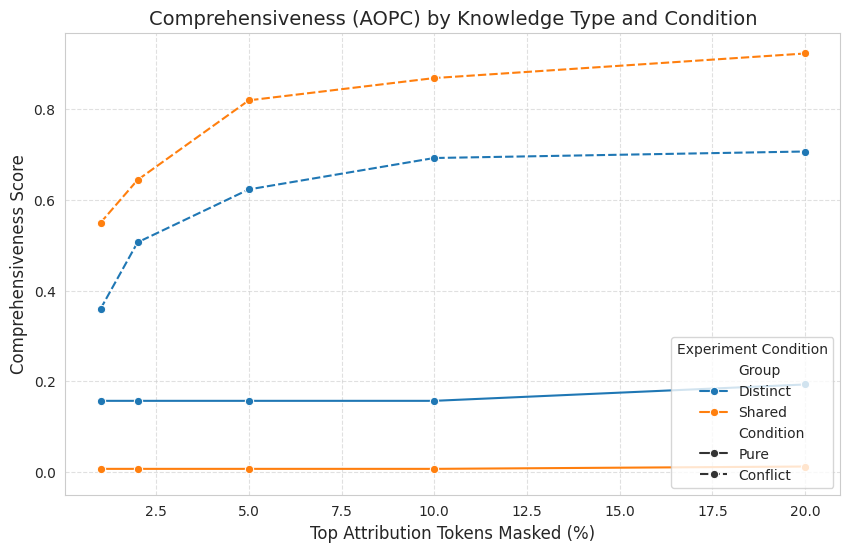

In [100]:
plot_comprehensiveness(df)

### 2. Sufficiency

* 문맥 속 IG를 통해 중요하다고 판단한 상위 K%의 토큰을 남겼을 경우 얼마나 차이나는지 확인
* Random과 비교

In [107]:
set_seed(42)

SAMPLE_K = 50
PERCENT_K_LIST = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

In [108]:
def masking_inputs_sufficiency(
    ig_input: IGInputs,
    attribution_scores: torch.Tensor,
    start_pos: int,
    end_pos: int,
    percent_k: float
) -> torch.Tensor:
    input_ids = ig_input.input_ids.clone()
    segment_len = end_pos - start_pos + 1

    # Sort by absolute attribution scores
    attr_scores_abs = torch.abs(attribution_scores[0])  # (Seq_Len, Dim)
    attr_scores_abs = attr_scores_abs.sum(dim=-1)   # (Seq_Len,)
    attr_scores_abs_segment = attr_scores_abs[start_pos : end_pos + 1]
    
    # Keep Top-K%
    k_to_keep = max(1, int(segment_len * percent_k))
    topk_values, topk_indices = torch.topk(attr_scores_abs_segment, k_to_keep)
    all_relative_indices = torch.arange(segment_len, device=topk_indices.device)

    topk_set = set(topk_indices.tolist())
    indices_to_mask_relative = [
        i for i in all_relative_indices.tolist() if i not in topk_set
    ]

    # Masking process
    real_indices_to_mask = torch.tensor(indices_to_mask_relative) + start_pos
    input_ids[0, real_indices_to_mask] = ig_input.baseline_id  # Mask with baseline_id

    return input_ids


In [109]:
from tqdm import tqdm

for percent_k in tqdm(PERCENT_K_LIST, desc="Processing different masking percentages"):
    print(f"\n=== Keeping {percent_k*100:.2f}% of attributions ===") 
    for idx in tqdm(sample_ids, desc=f"Keeping K={percent_k*100:.1f}%", position=1, leave=False):
        # Distinct / Shared
        if idx in sample_distinct_ids:
            inspection_attr = sample_distinct_attrs[idx]
        else:
            inspection_attr = sample_shared_attrs[idx]

        for case_type in ["pure", "conflict"]:
            ig_input = all_ig_inputs[idx][case_type]

            if case_type == "pure":
                attribution_tensor = inspection_attr[case_type]["target_attr"]
            else:
                attribution_tensor = inspection_attr[case_type]["conflict_attr"]
                
            start_pos, end_pos = inspection_attr[case_type]["context_pos"]

            # Masking
            masked_input_ids = masking_inputs_sufficiency(
                ig_input,
                attribution_tensor,
                start_pos,
                end_pos,
                percent_k
            )

            # Calculate new probability
            new_prob = calculate_sequence_prob(
                model,
                masked_input_ids,
                ig_input.target_pos_idx
            )

            # Store result
            if "keeping_results" not in inspection_attr[case_type]:
                inspection_attr[case_type]["keeping_results"] = {}
            
            inspection_attr[case_type]["keeping_results"][percent_k] = new_prob


=== Keeping 1.00% of attributions ===



=== Keeping 2.00% of attributions ===



=== Keeping 5.00% of attributions ===



=== Keeping 10.00% of attributions ===



=== Keeping 20.00% of attributions ===



=== Keeping 30.00% of attributions ===



=== Keeping 40.00% of attributions ===



=== Keeping 50.00% of attributions ===


Processing different masking percentages: 100%|██████████| 8/8 [02:00<00:00, 15.03s/it]


In [110]:
sufficiency_results = {
    "distinct": {},
    "shared": {}
}

for key in ["distinct", "shared"]:
    if key == "distinct":
        sample_attrs = sample_distinct_attrs
    else:
        sample_attrs = sample_shared_attrs

    for idx, inspection_attr in tqdm(sample_attrs.items(), desc=f"Computing sufficiency for {key} samples"):
        sufficiency_results[key][idx] = {
            "pure": {},
            "conflict": {}
        }
        for case_type in ["pure", "conflict"]:
            base_prob = base_inference_results[idx][case_type]
            keeping_results = inspection_attr[case_type].get("keeping_results", {})

            for percent_k, masked_prob in keeping_results.items():
                sufficiency_results[key][idx][case_type][percent_k] = masked_prob

Computing sufficiency for shared samples: 100%|██████████| 50/50 [00:00<00:00, 146962.30it/s]


In [111]:
summary_results = get_summary(sufficiency_results, PERCENT_K_LIST)
summary_results

{'distinct': {'pure': {0.01: 0.5560994781285991,
   0.02: 0.5560994781285991,
   0.05: 0.5560994781285991,
   0.1: 0.5561059631139506,
   0.2: 0.562813931722194,
   0.3: 0.5853356850892305,
   0.4: 0.6459121757745743,
   0.5: 0.674629225730896},
  'conflict': {0.01: 0.10128217416153347,
   0.02: 0.136083687255159,
   0.05: 0.18177483298437436,
   0.1: 0.185536877324339,
   0.2: 0.3051545723338495,
   0.3: 0.34385885182768106,
   0.4: 0.3906407042592764,
   0.5: 0.5246276533603669}},
 'shared': {'pure': {0.01: 0.9587109375,
   0.02: 0.9587109375,
   0.05: 0.9587109375,
   0.1: 0.9587109375,
   0.2: 0.960703125,
   0.3: 0.961171875,
   0.4: 0.935,
   0.5: 0.95734375},
  'conflict': {0.01: 0.17824377776123584,
   0.02: 0.19232182838997688,
   0.05: 0.267636743709445,
   0.1: 0.3088568575307727,
   0.2: 0.36360599994659426,
   0.3: 0.47354320108890535,
   0.4: 0.5461613583564758,
   0.5: 0.6391482496261597}}}

In [112]:
import pandas as pd

data_list = []
for group_key, group_data in summary_results.items():
    for case_type, scores in group_data.items():
        for percent_k, score in scores.items():
            data_list.append({
                "Group": group_key.capitalize(),          # Distinct / Shared
                "Condition": case_type.capitalize(),      # Pure / Conflict
                "Kepping_Percentage": percent_k * 100,     # K%
                "Suff_Score": score
            })
df = pd.DataFrame(data_list)
df

,Group,Condition,Kepping_Percentage,Suff_Score
0,Distinct,Pure,1.0,0.556099
1,Distinct,Pure,2.0,0.556099
2,Distinct,Pure,5.0,0.556099
3,Distinct,Pure,10.0,0.556106
4,Distinct,Pure,20.0,0.562814
5,Distinct,Pure,30.0,0.585336
6,Distinct,Pure,40.0,0.645912
7,Distinct,Pure,50.0,0.674629
8,Distinct,Conflict,1.0,0.101282
9,Distinct,Conflict,2.0,0.136084


In [114]:
import seaborn as sns

def plot_sufficiency(df: pd.DataFrame, do_save: bool = False) -> None:
    """
    4가지 실험 조건(Distinct/Shared, Pure/Conflict)에 대한 Sufficiency Score의 
    AOPC (Area Over Perturbation Curve) 그래프를 그립니다.

    Args:
        df: 'Group', 'Condition', 'Kepping_Percentage', 'Suff_Score' 컬럼을 포함하는 DataFrame.
    """
    sns.set_style("whitegrid")
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df, 
        x="Kepping_Percentage", 
        y="Suff_Score", 
        hue="Group",        
        style="Condition",    
        marker="o",           
        dashes=True,          
        errorbar=None         
    )

    # 제목 및 축 레이블 설정
    plt.title("Sufficiency (AOPC) by Knowledge Type and Condition", fontsize=14)
    plt.xlabel("Top Attribution Tokens Keeped (%)", fontsize=12)
    plt.ylabel("Sufficiency Score", fontsize=12)

    plt.legend(title="Experiment Condition", loc='lower right')
    plt.ylim(bottom=-0.05) 
    plt.grid(True, linestyle='--', alpha=0.6)
    
    if do_save:
        plt.savefig("ig_attrs/sufficiency_aopc.png", dpi=300)
        plt.close()
    else:
        plt.show()

In [115]:
plot_comprehensiveness(df, do_save=True)

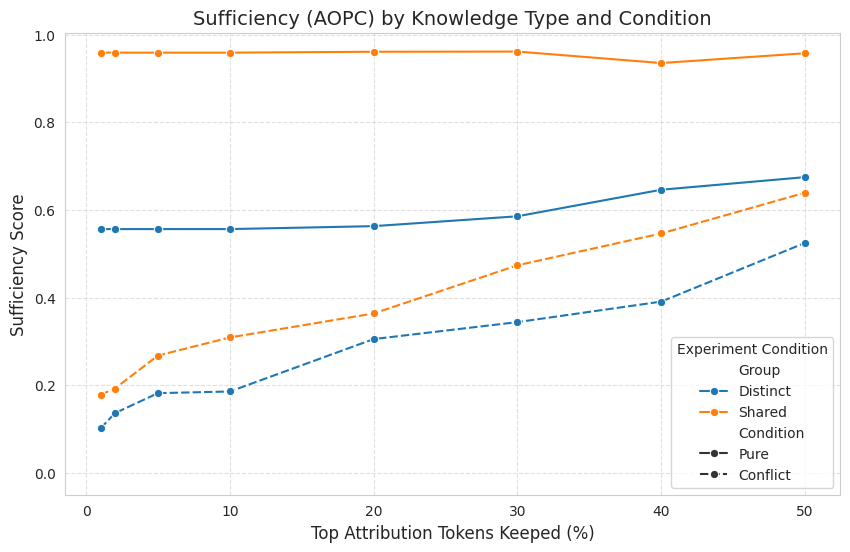

In [116]:
plot_comprehensiveness(df)